# Markov Chain Model for Predicting Men's College Basketball Games

* See Diagram explaining Markov Chain process

For the initial team-level Markov Chain model, all stats will be taken as per game stats at the team level. Future work will seek to refine this approach by modeling player-level dynamics.

Stats of Interest:
 * Offensive Rebounding Efficiency (Offensive Rebounds / Offensive Rebound Opportunities)
 * Two-Point Attempts 
 * Three-Point Attempts
 * Two-Point Shooting Percentage (Shots Made / Shots Attempted)
 * Three-Point Shooting Percentage
 * Opponent Free Throw attempts
 * Free Throw attempts
 * Free Throw Percentage
 * Turnovers
 * Opponent Turnovers
 * AdjT (KenPom Adjusted Tempo)
 
*Data Format*: Initial explorations of this model will utilize end-of-season stats for each team, as it is difficult to accurately time-slice historical stats. However, it is important to note that this will essentially allow the model to be trained on the test data (If a team's end-of-season stats were good, its likely that they won games), which could result in an artifically inflated predictive capability. Future work will seek to remedy this leakage by either projecting the previous season's stats forward or by only using stats up to the game in question. Finally, time and opponent weighting can be added to the stats in order to more accurately capture the team's ability at a given moment in time. This project's primary data sources are listed below:
 * [Year] Stats: The stats of interest for each D-1 NCAA team for a given year. This will likely be stored in a csv file for easy storage and retrieval, and will be loaded into a pandas dataframe for use within the project.
 * [Year] Results: Every game between two D-1 NCAA teams in a given season, with the resulting scores. Similarly to the stats, this will be stored in a csv file and loaded into a pandas dataframe for project use.
    
Assumptions:
 * As the two outcomes of fouls are free throws or a turnover, we use these two stats in the model instead of the number of fouls
     * We do not care if a turnover is a result of a foul, error, or steal, as these are all functionally identical
     * We assume that free throws are shot 2 at a time, independently of two and three point shots. While this is quite different to how free throws function in actuality, this should still accurately capture a team's scoring from the free throw line. Additionally, we assume that there are no offensive rebounds after free-throws, as teams rarely contest free throws.
 * The total amount of possessions in the game is the sum of both teams' KenPom Adjusted Tempo. As a result, teams who tend to run at higher tempo will have more event-dense games. We do not dictate a set number of possessions per team as that would defeat the stochastic nature of the Markov Chain Model
     * Each shot represents the end of one possession, even if the shooting team recovers their shot (offensive rebound)
 * Whether a team shoots a three-pointer or two-pointer is based on their ratio of three-point attempts to two-point attempts
 * Whether a team makes a shot or not is modeled as a Bernoulli random variable, where the probability of success is their shooting percentage for the shot type. Currently does not account for defense of other team.
     * Similarly, whether a team has an offensive rebound is modeled as a Bernoulli random variable, where the probability of success is their offensive rebounding efficiency. This was chosen due both to its simplicity and by assuming defensive rebounds as the default. This could be refined in the future by accounting for the opposing team's defensive rebounding efficiency.

### Step 1: Create Markov Chain Model

In [89]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys
import time
import re
import requests
from bs4 import BeautifulSoup

class MarkovModel:
    def __init__(self, stats, home, away):
        '''Model Inputs:
            * stats (df): Pandas dataframe containing stats of interest for D-1 Teams
            * home (str): Home team name
            * away (str): Away team name'''
        self.states = ["Home Team Possession", "Away Team Possession", "Home 3PT Shot", "Home 2PT Shot", "Home FT Shot",
                       "Home 3PT Made", "Home 2PT Made", "Home Miss", "Away 3PT Shot", "Away 2PT Shot", "Away FT Shot", 
                       "Away 3PT Made", "Away 2PT Made", "Away Miss"]
        self.state_locations = np.arange(0,len(self.states))
        self.transition_matrix = self.create_transition_matrix(stats, home, away)
        #Store inputs after transition matrix has been generated
        self.home = home
        self.away = away
        self.home_ft_pct = stats.loc[home]["FT%"]
        self.away_ft_pct = stats.loc[away]["FT%"]
        self.total_possessions = stats.loc[home]["AdjT"] + stats.loc[away]["AdjT"]
        
    def create_transition_matrix(self, stats, home, away):
        home_stats = stats.loc[home]
        away_stats = stats.loc[away]
        home_turnover_rate = (home_stats["Turnovers"]+away_stats["Opp Turnovers"])/(2*home_stats["AdjT"])
        away_turnover_rate = (away_stats["Turnovers"]+home_stats["Opp Turnovers"])/(2*away_stats["AdjT"])
        home_shot_ratio = home_stats["2PTA"]/home_stats["3PTA"]
        away_shot_ratio = away_stats["2PTA"]/away_stats["3PTA"]
        home_ft_rate = (home_stats["FTA"]+away_stats["Opp FTA"])/(4*home_stats["AdjT"])
        away_ft_rate = (away_stats["FTA"]+home_stats["Opp FTA"])/(4*away_stats["AdjT"])
        transition_matrix = np.zeros((len(self.states),len(self.states)))
        transition_matrix[0,1] = home_turnover_rate
        transition_matrix[0,2] = (1-home_turnover_rate-home_ft_rate)/(home_shot_ratio+1)
        transition_matrix[0,4] = home_ft_rate
        transition_matrix[0,3] = 1 - sum(transition_matrix[0,:])
        transition_matrix[1,0] = away_turnover_rate
        transition_matrix[1,7] = (1-away_turnover_rate-away_ft_rate)/(away_shot_ratio+1)
        transition_matrix[1,10] = away_ft_rate
        transition_matrix[1,8] = 1 - sum(transition_matrix[1,:])
        transition_matrix[2,5] = home_stats["3PT%"]
        transition_matrix[2,7] = 1 - home_stats["3PT%"]
        transition_matrix[3,6] = home_stats["2PT%"]
        transition_matrix[3,7] = 1 - home_stats["2PT%"]
        transition_matrix[4:7,1] = 1
        transition_matrix[7,0] = home_stats["ORB%"]
        transition_matrix[7,1] = 1 - home_stats["ORB%"]
        transition_matrix[8,11] = home_stats["3PT%"]
        transition_matrix[8,13] = 1 - home_stats["3PT%"]
        transition_matrix[9,12] = home_stats["2PT%"]
        transition_matrix[9,13] = 1 - home_stats["2PT%"]
        transition_matrix[10:13,0] = 1
        transition_matrix[13,0] = 1 - away_stats["ORB%"]
        transition_matrix[13,1] = away_stats["ORB%"]
        valid = True
        for i in range(len(self.states)):
            if not np.isclose(sum(transition_matrix[i,:]), 1):
                valid = False
                break
        if not valid:
            print("Error in Transition Matrix")
            print(transition_matrix[i,:])
            sys.exit()
        return transition_matrix
    
    def simulate_game(self):
        self.current_state = int(np.round(np.random.uniform())) #Simulate coin flip for opening possession (Either 0 or 1)
        self.home_score = 0
        self.away_score = 0
        poss = 1
        while poss < self.total_possessions:
            # Transition to new state based on transition matrix
            self.current_state = np.random.choice(self.state_locations, replace=True, p=self.transition_matrix[self.current_state])
            if (self.current_state == 0) or (self.current_state == 1):
                #If a team has just gained possession, increment possession counter
                poss += 1
            elif self.current_state == 4:
                #Simulate free throws
                self.home_score += np.random.binomial(2, self.home_ft_pct)
            elif self.current_state == 5:
                #Increment scoring as appropriate
                self.home_score += 3
            elif self.current_state == 6:
                self.home_score += 2
            elif self.current_state == 10:
                self.away_score += np.random.binomial(2, self.away_ft_pct)
            elif self.current_state == 11:
                self.away_score += 3
            elif self.current_state == 12:
                self.away_score += 2
            

### Step 2: Collect Historical Data 

Monte Carlo Markov Chain Simulation. Final Score: Purdue-60.037, Michigan State-51.887
Total Simulation Time: 4.5797 seconds


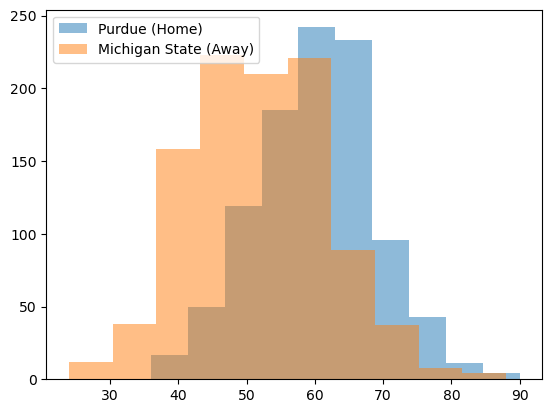

In [24]:
t1 = time.time()
last_year_stats = pd.read_csv("2021-22 Stats Mk2.csv", index_col=0)
last_year_markov_model = MarkovModel(last_year_stats, "Purdue", "Michigan State")
home_scores = []
away_scores = []
for i in range(1000):
    last_year_markov_model.simulate_game()
    home_scores.append(last_year_markov_model.home_score)
    away_scores.append(last_year_markov_model.away_score)
    
t2 = time.time()
print("Monte Carlo Markov Chain Simulation. Final Score: {}-{}, {}-{}".format(last_year_markov_model.home, np.mean(home_scores), last_year_markov_model.away, np.mean(away_scores)))
print("Total Simulation Time: {:.4f} seconds".format(t2-t1))
plt.hist(home_scores, alpha=0.5, label="Purdue (Home)")
plt.hist(away_scores, alpha=0.5, label="Michigan State (Away)")
plt.legend()

As we can see above, performing a Monte Carlo Simulation with our Markov Chain model produces the expected normal distributions for each team's score in the given matchup. As expected, there is a large degree of overlap between the two distributions, which represents the significant amount of uncertainty present in any given matchup. The model takes approximately 15 seconds to simulate 1,000 games, which is sufficient for confidently declaring a predicted winner. The algorithm is $O(N)$ with regards to number of games being simulated, so simulating larger numbers of games (>10,000) is feasible if desired. Simulating an entire season (\~5,000 matchups) at 1,000 sims per matchup would take \~20 hours to finish, so we will use 100 sims per matchup for our historical backtesting (\~2 hours).

[Backtest against historical data]

In [51]:
odds_df = pd.read_csv("2021-22 Odds.csv")
stats_df = pd.read_csv("2021-22 Stats Mk2.csv")

odds_df["Date"] = pd.to_datetime(odds_df["Date"], format="t%m%d%Y")
home_predictions = []
away_predictions = []
for matchup in odds_df.itertuples(index=False, name=None):
    print(matchup[0])
    try:
        mm = MarkovModel(stats_df, matchup[1], matchup[4])
        home_scores = []
        away_scores = []
        for i in range(100):
            mm.simulate_game()
            home_scores.append(mm.home_score)
            away_scores.append(mm.away_score)
        home_predictions.append(np.mean(home_scores))
        away_predictions.append(np.mean(away_scores))
    except:
        print("Key Error, Teams: {}, {}".format(matchup[1], matchup[4]))
        break

odds_df["Home Predictions"] = home_predictions
odds_df["Away Predictions"] = away_predictions
odds_df.to_csv("2021-22 Markov Preds Mk2.csv")

2021-11-09 00:00:00
Key Error, Teams: UC San Diego, California


ValueError: Length of values (0) does not match length of index (5343)

Text(0, 0.5, 'Predicted Scores')

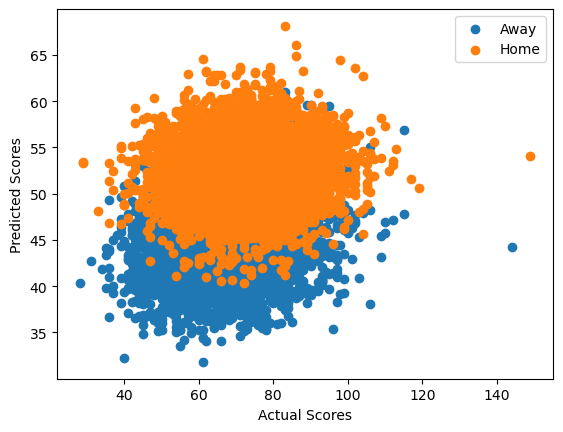

In [26]:
results_df = pd.read_csv("2021-22 Markov Preds Mk2.csv", index_col = 0)
plt.scatter(results_df["Away Score"], results_df["Away Predictions"], label="Away")
plt.scatter(results_df["Home Score"], results_df["Home Predictions"], label="Home")
plt.legend()
plt.xlabel("Actual Scores")
plt.ylabel("Predicted Scores")

Text(0, 0.5, 'Predicted Margin')

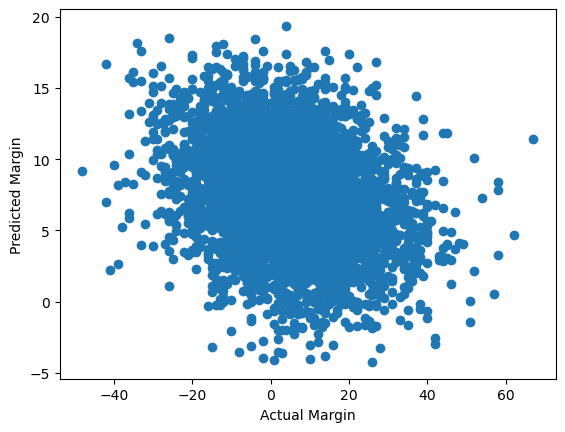

In [28]:
results_df["Home Margin"] = results_df["Home Score"] - results_df["Away Score"]
results_df["Predicted Margin"] = results_df["Home Predictions"] - results_df["Away Predictions"]
plt.scatter(results_df["Home Margin"], results_df["Predicted Margin"])
plt.xlabel("Actual Margin")
plt.ylabel("Predicted Margin")

In [27]:
def american_to_decimal(odds):
    #Convert American Odds to Decimal Odds
    if odds < 0: #If team is the favorite (negative american odds)
        decimal_odds = -1/(odds/100) + 1
    else:
        decimal_odds = (odds/100) + 1
    return decimal_odds

results_df["Away ML"] = results_df["Away ML"].astype(float)
results_df["Home ML"] = results_df["Home ML"].astype(float)
#Convert American odds to decimal odds
results_df['Away ML'] = results_df['Away ML'].apply(american_to_decimal)
results_df["Home ML"] = results_df["Home ML"].apply(american_to_decimal)


results_df["Markov Profit"] = np.where(results_df["Away Predictions"] > results_df["Home Predictions"], 
                                    np.where(results_df["Away Score"] > results_df["Home Score"], results_df["Away ML"]-1, -1),
                                    np.where(results_df["Home Score"] > results_df["Away Score"], results_df["Home ML"]-1, -1))

print("Markov Profit (Units/Game): {:.4f}".format(np.mean(results_df["Markov Profit"])))
print("Markov Accuracy: {:.2%}".format(np.mean(results_df["Markov Profit"] > 0)))
print("Cumulative Markov Profit (Units): {:.2f}".format(results_df["Markov Profit"].sum()))

Markov Profit (Units/Game): -0.0422
Markov Accuracy: 60.86%
Cumulative Markov Profit (Units): -225.29


## Future Improvements

* Analyze distribution of team stats per game to chose more accurate distributions
  * Current Model intrisincally assumes that shots, steals, and offensive rebounds follow a binomial distribution with mean *np*, which implies a variance of *np(1-p)* and symmetric distribution
  * However, maybe offensive rebounds (or another stat) follow a poisson distribution with mean and variance  $\lambda$
* Implement a player-level Markov Model

## Analysis of Stat Distributions

Collect historical game results to determine whether shots, turnover, and offensive rebounds follow a Binomial distribution or a poisson distribution.

In [62]:
stats_df = pd.read_csv("2021-22 Stats Mk2.csv")
teams = stats_df["School"]
#This code physically pains me, but apparently its literally the fastest/most correct way to do it
initial_clean = [("UC ", "california-"), ("UNC ", "north-carolina-"), (" ", "-"), ("(",""), (")",""), ("&",""),
                 (".",""), ("'",""), ("--","-")]

for pair in initial_clean:
    teams = teams.str.replace(pair[0], pair[1], regex=False)
teams = teams.str.lower()
#Individual team fixes
bespoke_clean = {"houston-christian":"houston-baptist", "little-rock":"arkansas-little-rock", "louisiana":"louisiana-lafayette",
                    "nc-state":"north-carolina-state", "purdue-fort-wayne":"ipfw", "siu-edwardsville":"southern-illinois-edwardsville",
                    "tcu":"texas-christian", "texas-rio-grande-valley":"texas-pan-american", "the-citadel":"citadel",
                    "uab":"alabama-birmingham", "ut-arlington":"texas-arlington", "utah-tech":"dixie-state", 
                    "utep":"texas-el-paso", "utsa":"texas-san-antonio", "vmi":"virginia-military-institute"}

for key, value in bespoke_clean.items():
    teams = teams.str.replace(key, value)
team_codes = list(teams)

In [94]:
#WOOOOOO LIST COMPREHENSION BABY
def extract_stat(soup, stat_code):
    return np.array([int(game.get_text()) for game in soup.find_all(attrs={"data-stat":stat_code}) if game.get_text().isnumeric()])

two_point_attempt_var = []
two_point_shot_var = []
three_point_attempt_var = []
three_point_shot_var = []
ft_attempt_var = []
ft_made_var = []
off_reb_var = []

t1 = time.time()
i = 0

for team_code in team_codes:
    print(team_code)
    team = requests.get("https://www.sports-reference.com/cbb/schools/"+team_code+"/men/2022-gamelogs.html")
    soup = BeautifulSoup(team.text)
    i += 1
    t2 = time.time()
    if ((t2-t1)/i) < 2:
        print("Time per team: {:.4f}".format((t2-t1)/i))
        #If accessing more than 30 sites per minute, throttle down requests to avoid triggering rate limiting
        time.sleep(2)
    
    free_throws = extract_stat(soup, "fta")
    free_throws_made = extract_stat(soup, "ft")
    field_goals = extract_stat(soup, "fga")
    three_point_shots = extract_stat(soup, "fg3a")
    field_goals_made = extract_stat(soup, "fg")
    three_points_made = extract_stat(soup, "fg3")
    off_reb = extract_stat(soup, "orb")
    # Extract two-pointers
    two_point_shots = field_goals - three_point_shots
    two_points_made = field_goals_made - three_points_made
    # Calculate variances
    two_point_attempt_var.append(np.var(two_point_shots))
    two_point_shot_var.append(np.var(two_points_made))
    three_point_attempt_var.append(np.var(three_point_shots))
    three_point_shot_var.append(np.var(three_points_made))
    ft_attempt_var.append(np.var(free_throws))
    ft_made_var.append(np.var(free_throws_made))
    off_reb_var.append(np.var(off_reb))

abilene-christian
Time per team: 0.1823
air-force
Time per team: 1.2316
akron
Time per team: 1.5805
alabama
Time per team: 1.7595
alabama-am
Time per team: 1.8642
alabama-state
albany-ny
Time per team: 1.7634
alcorn-state
Time per team: 1.8558
american
Time per team: 1.9048
appalachian-state
Time per team: 1.9422
arizona
Time per team: 1.9740
arizona-state
arkansas
Time per team: 1.8748
arkansas-state
Time per team: 1.9051
arkansas-pine-bluff
Time per team: 1.9574
army
Time per team: 1.9775
auburn
Time per team: 1.9957
austin-peay
ball-state
Time per team: 1.9196
baylor
Time per team: 1.9387
bellarmine
Time per team: 1.9574
belmont
Time per team: 1.9736
bethune-cookman
Time per team: 1.9866
binghamton
Time per team: 1.9993
boise-state
boston-college
Time per team: 1.9624
boston-university
Time per team: 1.9750
bowling-green-state
Time per team: 1.9863
bradley
Time per team: 1.9970
brigham-young
brown
Time per team: 1.9516
bryant
Time per team: 1.9617
bucknell
Time per team: 1.9714
buff

south-carolina
Time per team: 1.9977
south-carolina-state
south-carolina-upstate
Time per team: 1.9941
south-dakota
Time per team: 1.9952
south-dakota-state
Time per team: 1.9963
south-florida
Time per team: 1.9974
southeast-missouri-state
Time per team: 1.9985
southeastern-louisiana-lafayette
Time per team: 1.9995
southern
southern-california
Time per team: 1.9941
southern-illinois
Time per team: 1.9990
southern-illinois-edwardsville
southern-methodist
Time per team: 1.9958
southern-mississippi
Time per team: 1.9968
southern-utah
Time per team: 1.9979
st-bonaventure
Time per team: 1.9989
st-francis-ny
st-johns-ny
Time per team: 1.9958
st-thomas-mn
Time per team: 1.9968
stanford
Time per team: 1.9979
stephen-f-austin
Time per team: 1.9989
stetson
stony-brook
Time per team: 1.9963
syracuse
Time per team: 1.9973
tarleton-state
Time per team: 1.9983
texas-christian
Time per team: 1.9992
temple
tennessee
Time per team: 1.9945
tennessee-state
Time per team: 1.9954
tennessee-tech
Time per te

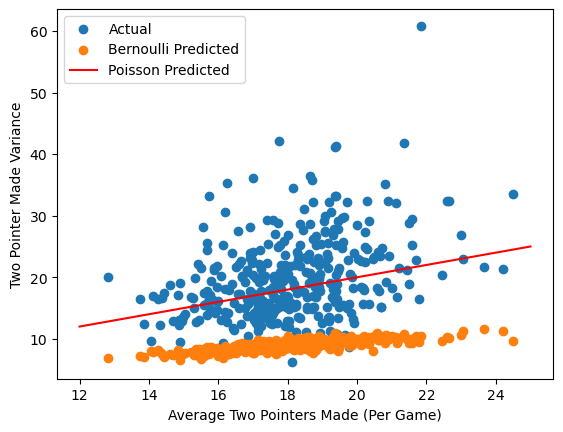

In [103]:
x = np.linspace(12,25,100)
plt.scatter(stats_df["2PTA"]*stats_df["2PT%"], two_point_shot_var, label="Actual")
plt.scatter(stats_df['2PTA']*stats_df["2PT%"], stats_df["2PTA"]*stats_df["2PT%"]*(1-stats_df["2PT%"]), label="Bernoulli Predicted")
plt.plot(x,x, "r", label="Poisson Predicted")
plt.xlabel("Average Two Pointers Made (Per Game)")
plt.ylabel("Two Pointer Made Variance")
plt.legend()

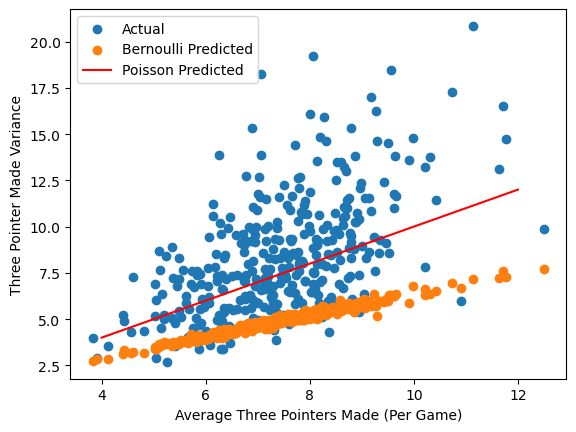

In [106]:
x = np.linspace(4,12,100)
plt.scatter(stats_df["3PTA"]*stats_df["3PT%"], three_point_shot_var, label="Actual")
plt.scatter(stats_df['3PTA']*stats_df["3PT%"], stats_df["3PTA"]*stats_df["3PT%"]*(1-stats_df["3PT%"]), label="Bernoulli Predicted")
plt.plot(x,x, "r", label="Poisson Predicted")
plt.xlabel("Average Three Pointers Made (Per Game)")
plt.ylabel("Three Pointer Made Variance")
plt.legend()